In [3]:
# %% [code]
# 1) 필수 라이브러리 임포트
import numpy as np
import torch
from torch.optim import AdamW

# PyTorch DataLoader + custom collate
from torch.utils.data import DataLoader, random_split

# 프로젝트 모듈
from dataset.traffic_dataset import TrafficDataset
from dataset.dataset_config import edge_index, edge_attr
from models.baselines import GCNMLP, DCRNN, STGCN, STAEformer
from utils.Trainer import Trainer

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

In [ ]:
# 2) custom collate_fn 정의
def collate_fn(batch_list):
    # batch_list: list of Data(x=[T,E,C], y=[n_pred,E,D])
    xs = torch.stack([data.x for data in batch_list], dim=0)  # [B, T, E, C]
    ys = torch.stack([data.y for data in batch_list], dim=0)  # [B, n_pred, E, D]
    return xs, ys

# %% [code]
# 3) NumPy 트래픽 데이터 로드 및 형태 확인
dataset_np = np.load('dataset/traffic_dataset_13.npy', allow_pickle=True)
print("Raw data shape:", dataset_np.shape)  # 예: (33600, 50, 5)

# %% [code]
# 4) PyG Dataset 생성 및 분할
dataset = TrafficDataset(dataset_np, window=12)

train_size = int(len(dataset) * 0.8)
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# DataLoader: collate_fn 적용
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)

# 배치 형태 확인
x_batch, y_batch = next(iter(train_loader))
print("x_batch:", x_batch.shape)  # [4, 12, 50, 5]
print("y_batch:", y_batch.shape)  # [4, 3, 50, 3]

# %% [code]
# 5) 모델 파라미터 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
E      = dataset.E            # 엣지 수
D_in   = x_batch.size(-1)     # 입력 채널 수 (5)
D_out  = y_batch.size(-1)     # 출력 채널 수 (3)
n_pred = y_batch.size(1)      # 예측 스텝 수 (3)

print(f"Device: {device}, E={E}, D_in={D_in}, D_out={D_out}, n_pred={n_pred}")

# %% [code]
# 6) 모델 초기화

models = {
    "STAEformer": STAEformer(
        num_nodes=E,
        in_steps=12,
        out_steps=12,
        steps_per_day=288,
        input_dim=3,
        output_dim=1,
        input_embedding_dim=24,
        tod_embedding_dim=24,
        dow_embedding_dim=24,
        spatial_embedding_dim=0,
        adaptive_embedding_dim=80,
        feed_forward_dim=128,
        num_heads=3,
        num_layers=3,
        dropout=0.1,
        use_mixed_proj=True,
    ).to(device)
}
models1 = {
   
    "GCNMLP": GCNMLP(
        num_nodes=E,
        node_feature_dim=D_in,
        pred_node_dim=D_out,
        n_pred=n_pred,
        encoder_embed_dim=32,
        encoder_depth=1,
        dropout=0.0,
        mlp_hidden_dim=16,
        mlp_pred_dropout=0.0
    ).to(device),

    "DCRNN": DCRNN(
        num_nodes=E,
        node_feature_dim=D_in,
        pred_node_dim=D_out,
        n_pred=n_pred,
        encoder_embed_dim=32,
        encoder_depth=1,
        K=2,
        dropout=0.0
    ).to(device),

    "STGCN": STGCN(
        num_nodes=E,
        node_feature_dim=D_in,
        pred_node_dim=D_out,
        n_pred=n_pred,
        encoder_embed_dim=32,
        encoder_depth=1,
        kernel_size=3,
        K=2,
        dropout=0.0
    ).to(device),

    "STAEformer": STAEformer(
        num_nodes=E,
        in_steps=12,
        out_steps=12,
        steps_per_day=288,
        input_dim=3,
        output_dim=1,
        input_embedding_dim=24,
        tod_embedding_dim=24,
        dow_embedding_dim=24,
        spatial_embedding_dim=0,
        adaptive_embedding_dim=80,
        feed_forward_dim=128,
        num_heads=3,
        num_layers=3,
        dropout=0.1,
        use_mixed_proj=True,
    ).to(device)
}

Raw data shape: (33600, 50, 5)
x_batch: torch.Size([4, 12, 50, 5])
y_batch: torch.Size([4, 3, 50, 3])
Device: cpu, E=50, D_in=5, D_out=3, n_pred=3



--- Training STAEformer for 5 epochs ---
x shape: torch.Size([4, 12, 50, 5])
tensor([[[0.0460, 0.0460, 0.0460,  ..., 0.0460, 0.0460, 0.0460],
         [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
         [0.0464, 0.0464, 0.0464,  ..., 0.0464, 0.0464, 0.0464],
         ...,
         [0.0476, 0.0476, 0.0476,  ..., 0.0476, 0.0476, 0.0476],
         [0.0477, 0.0477, 0.0477,  ..., 0.0477, 0.0477, 0.0477],
         [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479]],

        [[0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637],
         [0.0639, 0.0639, 0.0639,  ..., 0.0639, 0.0639, 0.0639],
         [0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641],
         ...,
         [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
         [0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655],
         [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656]],

        [[0.0057, 0.0057, 0.0057,  ..., 0.0057, 0.0057, 0.0057],
         [0.0059, 0.0059, 0.0059,  ..., 0.005

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 50 but got size 2 for tensor number 3 in the list.

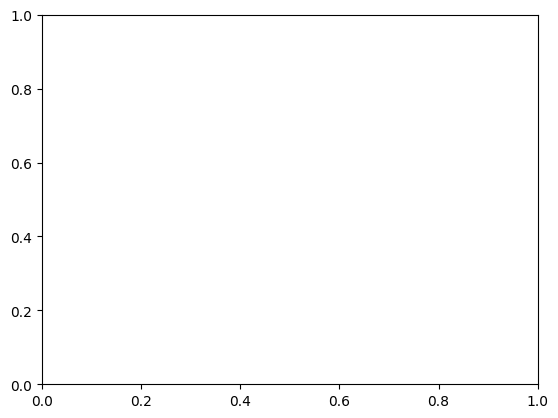

In [ ]:
# 7) 학습 실행: 각 모델당 5 에폭
histories = {}
for name, model in models.items():
    print(f"\n--- Training {name} for 5 epochs ---")
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)
    criterion = torch.nn.HuberLoss()
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=5,
        device=device,
        print_interval=1,
        plot_interval=5,
        early_stopping_patience=3
    )
    trainer.fit()
    histories[name] = trainer.get_history()

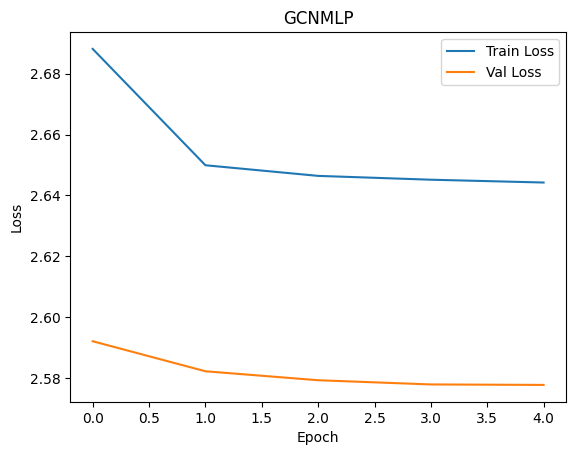

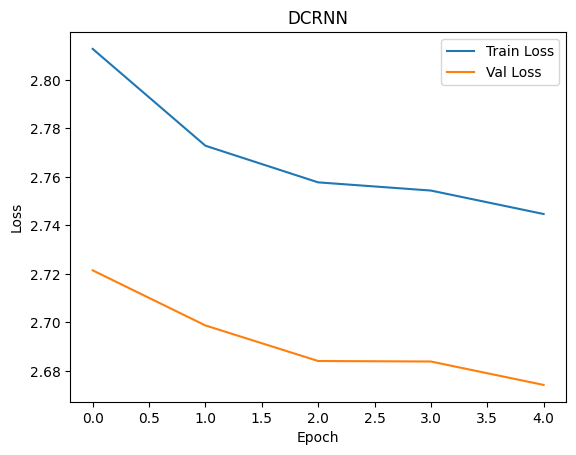

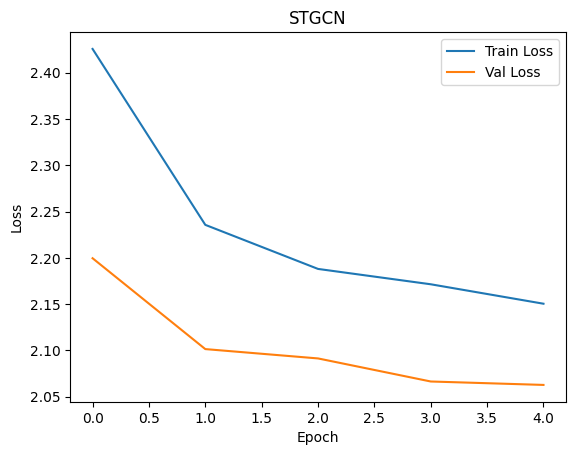

In [ ]:
import matplotlib.pyplot as plt

for name, hist in histories.items():
    plt.figure()
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['valid_loss'], label='Val Loss')
    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()